## import libs

In [291]:
import string
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from nltk import FreqDist
import seaborn as sns
from sklearn.metrics import confusion_matrix

nltk.download("averaged_perceptron_tagger_eng")
nltk.download("punkt_tab")
nltk.download("averaged_perceptron_tagger")

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\elsay\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\elsay\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\elsay\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [292]:
df = pd.read_csv("Spam_SMS.csv")

In [293]:
df.head()

,Class,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [294]:
df.isnull().sum()

Class      0
Message    0
dtype: int64

In [295]:
# Get most common words
all_words = []

for line in df["Message"]:
    words = line.split()
    for word in words:
        if len(word) > 2:
            all_words.append(word.lower())

Counter(all_words).most_common(50)

[('you', 1921),
 ('the', 1328),
 ('and', 968),
 ('for', 703),
 ('your', 677),
 ('have', 571),
 ('call', 559),
 ('are', 486),
 ('that', 470),
 ('but', 422),
 ('not', 410),
 ('can', 385),
 ('with', 379),
 ('will', 379),
 ("i'm", 377),
 ('get', 375),
 ('just', 365),
 ('this', 312),
 ('when', 283),
 ('from', 277),
 ('&lt;#&gt;', 276),
 ('all', 261),
 ('how', 254),
 ('what', 251),
 ('now', 247),
 ('like', 236),
 ('got', 235),
 ('know', 230),
 ('was', 230),
 ('free', 228),
 ('out', 220),
 ('come', 220),
 ('its', 208),
 ('then', 205),
 ('good', 201),
 ('send', 187),
 ('only', 184),
 ('want', 183),
 ('text', 175),
 ('time', 169),
 ("i'll", 168),
 ('love', 163),
 ('...', 163),
 ('going', 161),
 ('need', 157),
 ('about', 156),
 ('still', 151),
 ('one', 150),
 ('txt', 149),
 ('see', 145)]

## text preprocessing
 apply lemmatiztion 

In [296]:
stop_words = stopwords.words("english")


def text_preprocessing(text):
    # Make all words lowercase
    text = text.lower()

    # Remove  punction,number & spical char
    text = re.sub("[^a-zA-z]", " ", text)

    # Single char removel
    text = re.sub(r"\s+[a-zA-z]\s+", " ", text)

    # Remove multi spaces
    text = re.sub(r"\s+", " ", text)

    # Make a sentence to toknize
    tokens = word_tokenize(text)

    # Remove Stopwords
    final_token = [i for i in tokens if i not in stop_words]

    # Apply lemma
    final_words = []
    lemma = WordNetLemmatizer()
    for i in final_token:
        if len(i) > 2:
            word = lemma.lemmatize(i)
            final_words.append(word)
    return " ".join(final_words)

In [297]:
df["Clean_Text"] = df["Message"].apply(lambda x: text_preprocessing(x))
print("Text Preprocessing is done")

Text Preprocessing is done


In [298]:
df.head()

,Class,Message,Clean_Text
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis great world...
1,ham,Ok lar... Joking wif u oni...,lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win cup final tkts may te...
3,ham,U dun say so early hor... U c already then say...,dun say early hor already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think go usf life around though


In [299]:
df.drop(columns=["Message"], axis=1, inplace=True)
df.head()
x = df["Clean_Text"]
y = df["Class"]

In [300]:
text = " ".join(x.iloc[:5])

In [301]:
text

'jurong point crazy available bugis great world buffet cine got amore wat lar joking wif oni free entry wkly comp win cup final tkts may text receive entry question std txt rate apply dun say early hor already say nah think go usf life around though'

## Apply Feature Extraction

In [302]:
from gensim.models import Word2Vec
import numpy as np

# Convert text to list of words for Word2Vec
sentences = [text.split() for text in df["Clean_Text"]]

# Train Word2Vec model
w2v_model = Word2Vec(
    sentences,
    vector_size=100,  # Dimension of word vectors
    window=5,  # Context window size
    min_count=1,  # Ignore words that appear less than this
    workers=4,
)  # Number of threads to train the model


# Function to create document vectors by averaging word vectors
def document_vector(text, model):
    words = text.split()
    word_vecs = []
    for word in words:
        try:
            word_vecs.append(model.wv[word])
        except KeyError:
            continue
    if word_vecs:
        return np.mean(word_vecs, axis=0)
    else:
        return np.zeros(model.vector_size)


# Create document vectors for all texts
doc_vectors = np.array([document_vector(text, w2v_model) for text in df["Clean_Text"]])

# Now doc_vectors can be used like binary_vectorized in your model
# Shape will be (n_documents, vector_size)
print("Shape of document vectors:", doc_vectors.shape)

# Example: show vector for first document
print("\nVector for first document:", doc_vectors[0][:10], "...")

# Example: find most similar words to a specific word
word = "free"  # you can change this to any word in your dataset
if word in w2v_model.wv:
    print(f"\nMost similar words to '{word}':")
    similar_words = w2v_model.wv.most_similar(word)
    for w, score in similar_words:
        print(f"{w}: {score:.4f}")

Shape of document vectors: (5574, 100)

Vector for first document: [-0.11827609  0.0879715   0.01191796  0.01154932  0.03997365 -0.23065926
  0.01743294  0.32800576 -0.10767517 -0.0381148 ] ...

Most similar words to 'free':
text: 0.9996
mobile: 0.9996
reply: 0.9995
txt: 0.9995
msg: 0.9995
get: 0.9995
phone: 0.9995
one: 0.9995
stop: 0.9995
week: 0.9995


# apply pos tagging 

In [308]:
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
import numpy as np
from gensim.models import Word2Vec


def pos_tag_text(text):
    """
    Apply POS tagging to text and return tagged tokens
    """
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    # Return word_tag format
    return [f"{word}_{tag}" for word, tag in tagged]


# Add POS tagged text as a new feature
df["POS_Tagged"] = df["Clean_Text"].apply(pos_tag_text)

# Prepare sentences for Word2Vec (including POS tags)
pos_sentences = df["POS_Tagged"].tolist()

# Train Word2Vec model on POS tagged text
w2v_model_pos = Word2Vec(
    pos_sentences, vector_size=100, window=5, min_count=1, workers=4
)
df.head()

,Class,Clean_Text,POS_Tagged
0,ham,jurong point crazy available bugis great world...,"[jurong_JJ, point_NN, crazy_NN, available_JJ, ..."
1,ham,lar joking wif oni,"[lar_JJ, joking_NN, wif_NN, oni_NN]"
2,spam,free entry wkly comp win cup final tkts may te...,"[free_JJ, entry_NN, wkly_VBD, comp_NN, win_NN,..."
3,ham,dun say early hor already say,"[dun_NNS, say_VBP, early_JJ, hor_NN, already_R..."
4,ham,nah think go usf life around though,"[nah_RB, think_VBP, go_VB, usf_JJ, life_NN, ar..."


In [304]:
# Function to create document vectors with POS information
def document_vector_pos(tagged_tokens, model):
    word_vecs = []
    for token in tagged_tokens:
        try:
            word_vecs.append(model.wv[token])
        except KeyError:
            continue
    return np.mean(word_vecs, axis=0) if word_vecs else np.zeros(model.vector_size)


# Create document vectors for all texts
doc_vectors_pos = np.array(
    [document_vector_pos(tokens, w2v_model_pos) for tokens in df["POS_Tagged"]]
)

In [305]:
from sklearn.metrics import accuracy_score

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    doc_vectors_pos, y, test_size=0.2, random_state=42
)

# Train the model
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Make predictions
y_pred = dt.predict(X_test)

# Print results
print("\nAccuracy with POS-Word2Vec:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy with POS-Word2Vec: 0.8995515695067264

Classification Report:
              precision    recall  f1-score   support

         ham       0.95      0.93      0.94       954
        spam       0.64      0.70      0.67       161

    accuracy                           0.90      1115
   macro avg       0.79      0.82      0.80      1115
weighted avg       0.90      0.90      0.90      1115



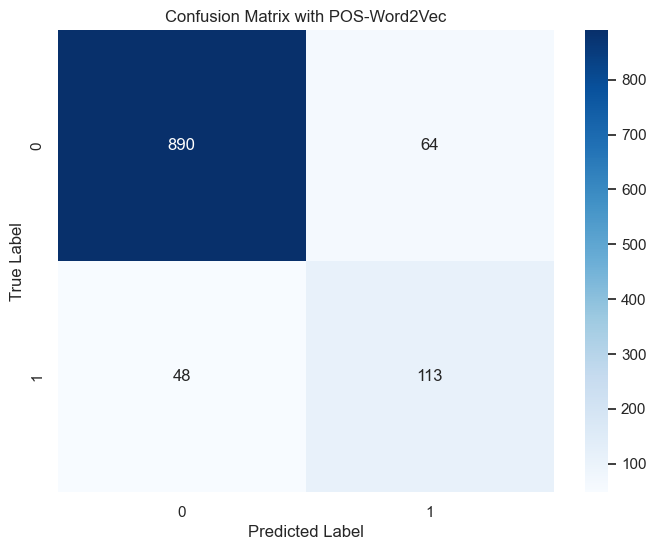


Example of POS tagged text and its vector:
Original: jurong point crazy available bugis great world buffet cine got amore wat
Tagged: ['jurong_JJ', 'point_NN', 'crazy_NN', 'available_JJ', 'bugis_NN', 'great_JJ', 'world_NN', 'buffet_NN', 'cine_NN', 'got_VBD', 'amore_RB', 'wat_JJ']
Vector (first 10 dimensions): [-0.01335188  0.02809127  0.01599224  0.005443    0.00555721 -0.04824656
  0.01387997  0.07396982 -0.02285094 -0.02141214]


In [306]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix with POS-Word2Vec")
plt.show()

# Example of vector representation
print("\nExample of POS tagged text and its vector:")
print("Original:", df["Clean_Text"].iloc[0])
print("Tagged:", df["POS_Tagged"].iloc[0])
print("Vector (first 10 dimensions):", doc_vectors_pos[0][:10])

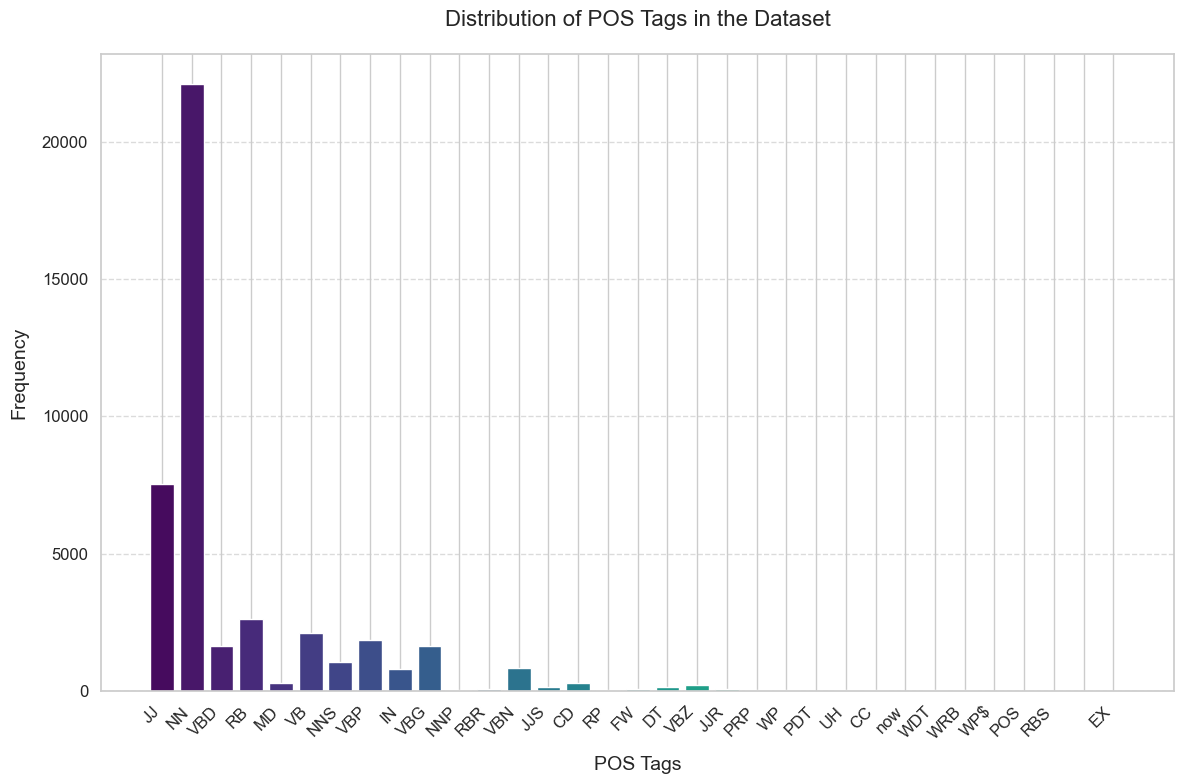


Number of unique POS tags: 33

POS Tag Counts:
Counter({'NN': 22104, 'JJ': 7526, 'RB': 2637, 'VB': 2107, 'VBP': 1842, 'VBD': 1651, 'VBG': 1642, 'NNS': 1068, 'VBN': 826, 'IN': 810, 'MD': 305, 'CD': 277, 'VBZ': 222, 'JJS': 155, 'DT': 154, 'JJR': 75, 'RBR': 71, 'FW': 62, 'CC': 49, 'WP': 47, 'NNP': 43, 'RP': 40, 'WRB': 34, 'PRP': 24, 'WDT': 20, 'UH': 18, 'RBS': 7, 'now': 3, 'WP$': 2, '': 2, 'PDT': 1, 'POS': 1, 'EX': 1})


In [307]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Extract all POS tags from the POS_Tagged column
all_tags = [
    tag.split("_")[1] for tagged_text in df["POS_Tagged"] for tag in tagged_text
]

# Count the occurrences of each POS tag
tag_counts = Counter(all_tags)

# Set the style for the plot
sns.set(style="whitegrid")

# Create a stylish bar plot with customized colors
plt.figure(figsize=(12, 8))
ax = plt.bar(
    tag_counts.keys(),
    tag_counts.values(),
    color=sns.color_palette("viridis", len(tag_counts)),
)

# Add labels and title with customized font sizes
plt.xlabel("POS Tags", fontsize=14, labelpad=10)
plt.ylabel("Frequency", fontsize=14, labelpad=10)
plt.title("Distribution of POS Tags in the Dataset", fontsize=16, pad=20)

# Rotate x-axis labels and adjust spacing
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)

# Add gridlines for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot with enhanced style
plt.tight_layout()
plt.show()

# Print the number of unique POS tags and their counts
print("\nNumber of unique POS tags:", len(tag_counts))
print("\nPOS Tag Counts:")
print(tag_counts)